# Compare the Different EQCM Runs

## Cluster the EQCM-D Data

In [23]:
import os
import pandas as pd
import numpy as np


folder = "/Users/leppin/Documents/SYNC/People/Christian/Electroresponsivity_Co3O4/Folder_For_DataBase/FastEQCM-D/"  # root directory
AllEQCMData = pd.DataFrame()

# loop over folders containing 'SmallLoadingRepeat'
for root, dirs, files in os.walk(folder):
    if "SmallLoadingRepeat" in os.path.basename(root):
        parquet_files = [f for f in files if f.endswith("AllEQCMData_indexed.parquet")]
        for pq_file in parquet_files:
            pq_path = os.path.join(root, pq_file)
            EQCMData = pd.read_parquet(pq_path)  # still reading as pickle
            AllEQCMData = pd.concat([AllEQCMData, EQCMData])

print(AllEQCMData.head())




                                                    time (s)  cycle  \
fname                                                                 
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...      0.00    1.0   
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...      0.02    1.0   
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...      0.04    1.0   
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...      0.06    1.0   
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...      0.08    1.0   

                                                    potential (V)  \
fname                                                               
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...       0.099803   
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...       0.099905   
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...       0.100007   
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...       0.100108   
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...       0.100210   

                  

## Select Cycle 3

In [24]:
SelectedData = AllEQCMData.loc[AllEQCMData['cycle']== 3]

<>:129: SyntaxWarning: invalid escape sequence '\m'
<>:161: SyntaxWarning: invalid escape sequence '\m'
<>:129: SyntaxWarning: invalid escape sequence '\m'
<>:161: SyntaxWarning: invalid escape sequence '\m'
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_93513/3453058085.py:129: SyntaxWarning: invalid escape sequence '\m'
  axs[0,1].set_ylabel('$\mathrm{mass_{geo}}$ \n ($\mathrm{\mu g \ cm^{-2}}$)')
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_93513/3453058085.py:161: SyntaxWarning: invalid escape sequence '\m'
  axs[1,0].set_ylabel('$d/dt(\mathrm{mass_{geo}})$ \n ($\mathrm{ ng \ cm^{-2} \ s^{-1}}$)')


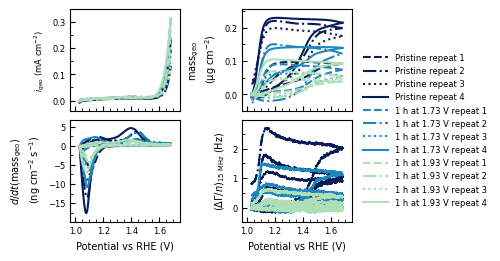

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib import cm
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import AutoMinorLocator

def convert_potential(E_old, pH=13, Eref_old = 0.165): 
    E_new = E_old + Eref_old + 0.059*pH
    return E_new


n_cycle = 3

def CalcSauerbreyMass(df_by_n: np.ndarray, Filter: bool = True) -> np.ndarray: 
    Zq = 8.8e6
    f0 = 5e6
    MassDensity = -df_by_n * Zq / (2*f0**2) * 1e5  # conversion of kg/m2 in ug/cm2
    return gaussian_filter1d(MassDensity, 150, axis=0) if Filter else MassDensity

def discard_points(y: np.ndarray, trsh: int) -> np.ndarray: 
    y[np.abs(y) > trsh] = np.nan
    return pd.Series(y).interpolate().to_numpy()

def colors(i):
    colors = cm.YlGnBu_r((i)*90)#cm.PuRd_r((i)*90)
    return colors

def make_color_label_line(df: pd.DataFrame) -> tuple[str, str, str]: 
    if set(df['info']) == {'pristine'}:
        color = colors(0)
        label = 'Pristine'
    elif set(df['info']) == {'0.8 V'}:
        color = colors(1) 
        label = '1 h at 1.73 V'
    elif set(df['info']) == {'1.0 V'}: 
        color = colors(2)
        label = '1 h at 1.93 V'

    if set(df['sample']) == {'#6'}:
        line = '--'
    elif set(df['sample']) == {'#8'}:
        line = '-.' 
    elif set(df['sample']) == {'#11'}:
        line = ':'
    elif set(df['sample']) == {'#18'}:
        line = '-'
    return color, label, line




SelectedData = AllEQCMData[AllEQCMData['cycle'].isin([n_cycle])]

SelectedData = SelectedData.copy()
SelectedData['info'] = ''
SelectedData['sample'] = ''



SelectedData.loc[SelectedData.index.get_level_values('fname').str.contains('at_0'),'info'] = '0.8 V'

SelectedData.loc[SelectedData.index.get_level_values('fname').str.contains('at_1'),'info'] = '1.0 V'

SelectedData.loc[SelectedData.index.get_level_values('fname').str.contains('init'),'info'] = 'pristine'

SelectedData.loc[SelectedData.index.get_level_values('fname').str.contains('#6'),'sample'] = '#6'

SelectedData.loc[SelectedData.index.get_level_values('fname').str.contains('#8'),'sample'] = '#8'

SelectedData.loc[SelectedData.index.get_level_values('fname').str.contains('#11'),'sample'] = '#11'

SelectedData.loc[SelectedData.index.get_level_values('fname').str.contains('#18'),'sample'] = '#18'

def sample_sort_key(s):
    if "initial" in s:
        return 0
    elif "at_0" in s:
        return 1
    elif "at_1" in s or "at_1V" in s:
        return 2
    else:
        return 3  # fallback

samples = sorted(set(SelectedData.index.get_level_values('fname')))
samples = sorted(samples, key=sample_sort_key)

# Legend
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['legend.frameon'] = False
# Axes
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.titlesize'] = 7
# Ticks
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=[3.5,2.5], constrained_layout = True)
axs[0,0].tick_params(which='both', direction="in")
def colors(i):
    colors = cm.YlGnBu_r((i)*90)#cm.PuRd_r((i)*90)
    return colors
for i_sample, sample in enumerate(samples):
    df = SelectedData.loc[(sample)]
    color, label, line = make_color_label_line(df)
    len_anodic_wave = len(df['df/n 3 (Hz)']) // 2

    # Plot current
    if set(df['sample']) == {'#18'}:
        axs[0,0].plot(convert_potential(df['potential (V)'].iloc[:len_anodic_wave]), df['current (mA)'].iloc[:len_anodic_wave],
                        linestyle=line, color=color, alpha = 1, label=f'{label} repeat {i_sample%4 +1}' )
    else: 
        axs[0,0].plot(convert_potential(df['potential (V)'].iloc[:len_anodic_wave]), df['current (mA)'].iloc[:len_anodic_wave],
                        linestyle=line, color=color, alpha = 1, label=f'{label} repeat {i_sample%4 +1}')
        
axs[0,0].set_ylabel(r'$i_{\mathrm{geo}} \ \mathrm{(mA \ cm^{-2}})$', fontsize=6)
axs[0,0].set_ylabel(r'$i_{\mathrm{geo}} \ \mathrm{(mA \ cm^{-2}})$')

ovt_keys_f = [SelectedData.keys()[4::2][0]]
axs[0,1].tick_params(which='both', direction="in", labelsize=6)
for i_sample, sample in enumerate(samples):
    df = SelectedData.loc[(sample)]
    color, label, line = make_color_label_line(df)
    SauerbreyMass = CalcSauerbreyMass(df['df/n 3 (Hz)'] - df['df/n 3 (Hz)'].iloc[0])
    axs[0,1].plot(convert_potential(df['potential (V)'].iloc[:len_anodic_wave]), SauerbreyMass[:len_anodic_wave],
                    linestyle=line, color=color, alpha = 1)
    axs[0,1].plot(convert_potential(df['potential (V)'].iloc[len_anodic_wave:]), SauerbreyMass[len_anodic_wave:],
                    linestyle=line, color=color, alpha = 1)
axs[0,1].set_ylabel('$\mathrm{mass_{geo}}$ \n ($\mathrm{\mu g \ cm^{-2}}$)')
axs[0,1].tick_params(which='both', direction = 'in')



ovt_keys_g = [SelectedData.keys()[5::2][0]]
axs[1,1].tick_params(which='both', direction="in")
for i_sample, sample in enumerate(samples):
    df = SelectedData.loc[(sample)]
    color, label, line = make_color_label_line(df)
    for i_ovt, ovt_key in enumerate(ovt_keys_g):
        axs[1,1].plot(convert_potential(df['potential (V)'].iloc[:len_anodic_wave]), (df[ovt_key] - df[ovt_key].iloc[0]).iloc[:len_anodic_wave],
                            linestyle=line, color=color, alpha = 1)
        axs[1,1].plot(convert_potential(df['potential (V)'].iloc[len_anodic_wave:]), (df[ovt_key] - df[ovt_key].iloc[0]).iloc[len_anodic_wave:],
                           linestyle=line, color=color, alpha = 1)

axs[1,1].set_ylabel(r'$(\Delta \Gamma/n)_{15 \ \mathrm{MHz}}$ (Hz)')
axs[1,1].set_xlabel('Potential vs RHE (V)')
axs[1,0].set_xlabel('Potential vs RHE (V)')

axs[1,0].tick_params(which='both', direction="in")
for i_sample, sample in enumerate(samples):
    df = SelectedData.loc[(sample)]
    color, label, line = make_color_label_line(df)
    SauerbreyMass = CalcSauerbreyMass(df['df/n 3 (Hz)'] - df['df/n 3 (Hz)'].iloc[0])
    time = df['time (s)'].to_numpy()
    rate = (np.roll(SauerbreyMass, -1) - SauerbreyMass) / (time[1] - time[0])*1000
    rate = rate[5:-5]
    axs[1,0].plot(convert_potential(df['potential (V)'].iloc[5:-5].iloc[:len_anodic_wave]), rate[:len_anodic_wave],
                       linestyle=line, color=color, alpha = 1)
    axs[1,0].plot(convert_potential(df['potential (V)'].iloc[5:-5].iloc[len_anodic_wave:]), rate[len_anodic_wave:],
                       linestyle=line, color=color, alpha = 1)
axs[1,0].set_ylabel('$d/dt(\mathrm{mass_{geo}})$ \n ($\mathrm{ ng \ cm^{-2} \ s^{-1}}$)')

for ax in np.ravel(axs):
    ax.margins(x=0.1, y=0.1)
    ax.set_xticks([1.0, 1.2, 1.4, 1.6])
    ax.yaxis.set_minor_locator(AutoMinorLocator(n = 2))
    ax.xaxis.set_minor_locator(AutoMinorLocator(n = 4))
fig.legend(frameon = False, handlelength=3, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig(fname=f"all_result_{n_cycle}_comparison_SmallLoading.tif", dpi=600, pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight', transparent = True)
plt.show()

## Cluster all Tafel Slopes

In [26]:
import os
import pandas as pd
import numpy as np

folder = "/Users/leppin/Documents/SYNC/People/Christian/Electroresponsivity_Co3O4/Folder_For_DataBase/FastEQCM-D/"  # root directory
AllTafelData = pd.DataFrame()

# loop over folders containing 'SmallLoadingRepeat'
for root, dirs, files in os.walk(folder):
    if "SmallLoadingRepeat" in os.path.basename(root):
        parquet_files = [f for f in files if f.endswith("_all.parquet")]
        for pq_file in parquet_files:
            print(pq_file)
            pq_path = os.path.join(root, pq_file)
            TafelData = pd.read_parquet(pq_path)
            AllTafelData = pd.concat([AllTafelData, TafelData])

print(AllTafelData.head())

# Add info and sample columns
AllTafelData['info'] = ''
AllTafelData['sample'] = ''

AllTafelData.loc[AllTafelData.index.str.contains('at_0'), 'info'] = '1 h at 1.73 V'
AllTafelData.loc[AllTafelData.index.str.contains('at_1'), 'info'] = '1 h at 1.93 V'
AllTafelData.loc[AllTafelData.index.str.contains('initial'), 'info'] = 'Pristine'

AllTafelData.loc[AllTafelData.index.str.contains('#6'), 'sample'] = '#6'
AllTafelData.loc[AllTafelData.index.str.contains('#8'), 'sample'] = '#8'
AllTafelData.loc[AllTafelData.index.str.contains('#11'), 'sample'] = '#11'
AllTafelData.loc[AllTafelData.index.str.contains('#18'), 'sample'] = '#18'

# Sorting helper
def sample_sort_key(s):
    if "initial" in s:
        return 0
    elif "at_0" in s:
        return 1
    elif "at_1" in s or "at_1V" in s:
        return 2
    else:
        return 3  # fallback

samples = sorted(set(AllTafelData.index), key=sample_sort_key)
samples


R3_tafel_plot_data_all.parquet
R4tafel_plot_data_all.parquet
R2_tafel_plot_data_all.parquet
R1_tafel_plot_data_all.parquet
                                                    tafel slope     error  \
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...    80.774025  0.703758   
CL20250530_002_#11_Co3O4Nps_CV_5mVpers_after1h_...    83.734148  0.580130   
CL20250530_003_#11_Co3O4Nps_CV_5mVpers_after1h_...    89.024878  0.594212   
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...    80.497274  0.235142   
CL20250530_003_#11_Co3O4Nps_CV_5mVpers_after1h_...    91.056685  0.242149   

                                                    overpotential  \
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...       0.742386   
CL20250530_002_#11_Co3O4Nps_CV_5mVpers_after1h_...       0.739678   
CL20250530_003_#11_Co3O4Nps_CV_5mVpers_after1h_...       0.740460   
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...       0.732842   
CL20250530_003_#11_Co3O4Nps_CV_5mVpers_after1h_...       0.736605   


['CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq5_09_CV_C01.mpr',
 'CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_seq1_05_CV_C01.mpr',
 'CL20250526_001_#8_Co3O4Nps_CV_5mVpers_initial_seq1_05_CV_C01.mpr',
 'CL20250522_006_#6_Co3O4Nps_CV_5mVpers_initial_seq1_05_CV_C01.mpr',
 'CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq1_05_CV_C01.mpr',
 'CL20250526_001_#8_Co3O4Nps_CV_5mVpers_initial_seq4_06_CV_C01.mpr',
 'CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_seq4_06_CV_C01.mpr',
 'CL20250522_006_#6_Co3O4Nps_CV_5mVpers_initial_seq4_06_CV_C01.mpr',
 'CL20250526_003_#8_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq1_05_CV_C01.mpr',
 'CL20250616_003_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq1_05_CV_C01.mpr',
 'CL20250522_006_#6_Co3O4Nps_CV_5mVpers_after1h_CA_at_0p8V_MSE_eq_1p73V_RHE_seq1_05_CV_C01.mpr',
 'CL20250616_003_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq5_09_CV_C01.mpr',
 'CL20250522_006_#6_Co3O4Nps_CVafter1h_CA_at_0p8V_M

In [27]:
AllTafelData

tafel slope     error  \
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...    80.774025  0.703758   
CL20250530_002_#11_Co3O4Nps_CV_5mVpers_after1h_...    83.734148  0.580130   
CL20250530_003_#11_Co3O4Nps_CV_5mVpers_after1h_...    89.024878  0.594212   
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...    80.497274  0.235142   
CL20250530_003_#11_Co3O4Nps_CV_5mVpers_after1h_...    91.056685  0.242149   
CL20250530_002_#11_Co3O4Nps_CV_5mVpers_after1h_...    94.454034  0.302221   
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_...    75.892803  0.128195   
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_after_CA...    77.179163  0.125835   
CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA...    85.505755  0.084597   
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_...    77.535165  0.026083   
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_after_CA...    79.021256  0.032431   
CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA...    88.302871  0.035054   
CL20250526_001_#8_Co3O4Nps_CV_5mVpers_initial_s...    69.355261  0.185000   
CL20250526_004_#8_Co3O4Nps_CV_5mVpers_after_CA_...    80.215607  0.227517   
CL20250527_001_#8_Co3O4Nps_CV_5mVpers_after_CA_...    92.690114  0.256467   
CL20250526_003_#8_Co3O4Nps_CV_5mVpers_after_CA_...    81.298775  0.152826   
CL20250526_001_#8_Co3O4Nps_CV_5mVpers_initial_s...    85.339898  0.208972   
CL20250527_001_#8_Co3O4Nps_CV_5mVpers_after_CA_...    97.999830  0.096858   
CL20250522_006_#6_Co3O4Nps_CV_5mVpers_initial_s...    67.333172  0.054941   
CL20250522_006_#6_Co3O4Nps_CVafter1h_CA_at_0p8V...    75.266025  0.135410   
CL20250523_003_#6_Co3O4Nps_CV_5mVpers_after1h_C...    86.451327  0.143573   
CL20250522_006_#6_Co3O4Nps_CV_5mVpers_initial_s...    70.967225  0.064506   
CL20250523_002_#6_Co3O4Nps_CV_5mVpers_after1h_C...    72.850854  0.123063   
CL20250522_006_#6_Co3O4Nps_CV_5mVpers_after1h_C...    76.271633  0.093756   

                                                    overpotential  \
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...       0.742386   
CL20250530_002_#11_Co3O4Nps_CV_5mVpers_after1h_...       0.739678   
CL20250530_003_#11_Co3O4Nps_CV_5mVpers_after1h_...       0.740460   
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...       0.732842   
CL20250530_003_#11_Co3O4Nps_CV_5mVpers_after1h_...       0.736605   
CL20250530_002_#11_Co3O4Nps_CV_5mVpers_after1h_...       0.739996   
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_...       0.714630   
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_after_CA...       0.706690   
CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA...       0.709119   
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_...       0.719295   
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_after_CA...       0.707082   
CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA...       0.702502   
CL20250526_001_#8_Co3O4Nps_CV_5mVpers_initial_s...       0.731392   
CL20250526_004_#8_Co3O4Nps_CV_5mVpers_after_CA_...       0.724418   
CL20250527_001_#8_Co3O4Nps_CV_5mVpers_after_CA_...       0.733577   
CL20250526_003_#8_Co3O4Nps_CV_5mVpers_after_CA_...       0.721658   
CL20250526_001_#8_Co3O4Nps_CV_5mVpers_initial_s...       0.741697   
CL20250527_001_#8_Co3O4Nps_CV_5mVpers_after_CA_...       0.721691   
CL20250522_006_#6_Co3O4Nps_CV_5mVpers_initial_s...       0.723507   
CL20250522_006_#6_Co3O4Nps_CVafter1h_CA_at_0p8V...       0.724447   
CL20250523_003_#6_Co3O4Nps_CV_5mVpers_after1h_C...       0.710156   
CL20250522_006_#6_Co3O4Nps_CV_5mVpers_initial_s...       0.727310   
CL20250523_002_#6_Co3O4Nps_CV_5mVpers_after1h_C...       0.718928   
CL20250522_006_#6_Co3O4Nps_CV_5mVpers_after1h_C...       0.725029   

                                                             info before EIS  \
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...       Pristine         No   
CL20250530_002_#11_Co3O4Nps_CV_5mVpers_after1h_...  1 h at 1.73 V         No   
CL20250530_003_#11_Co3O4Nps_CV_5mVpers_after1h_...  1 h at 1.93 V         No   
CL20250529_001_#11_Co3O4Nps_CV_5mVpers_initial_...       Pristine        Yes   


In [28]:
AllTafelData[(AllTafelData['sample']=='#6') & (AllTafelData['before EIS']=='No')]['overpotential']

CL20250522_006_#6_Co3O4Nps_CV_5mVpers_initial_seq4_06_CV_C01.mpr                                0.723507
CL20250522_006_#6_Co3O4Nps_CVafter1h_CA_at_0p8V_MSE_eq_1p73V_RHE_seq4_06_CV_C01.mpr             0.724447
CL20250523_003_#6_Co3O4Nps_CV_5mVpers_after1h_CA_at_1p0V_MSE_eq_1p93V_RHE_seq4_06_CV_C01.mpr    0.710156
Name: overpotential, dtype: float64

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:82: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:82: SyntaxWarning: invalid escape sequence '\m'
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_93513/1493013216.py:13: SyntaxWarning: invalid escape sequence '\m'
  axs.set_ylabel('Tafel slope \n $\mathrm{(mV \ dec^{-1})}$', fontsize = 7)
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_93513/1493013216.py:82: SyntaxWarning: invalid escape sequence '\m'
  axs.set_ylabel('Overpotential vs RHE \n at 0.1 $\mathrm{mA \ cm^{-2} \ (V)}$', fontsize = 7)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname V identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


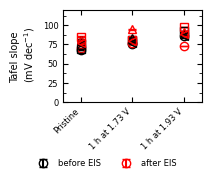

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


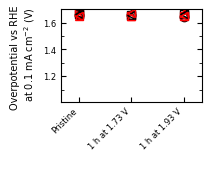

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

def convert_potential(E_old, pH=13, Eref_old = 0.165): 
    E_new = E_old + Eref_old + 0.059*pH
    return E_new

fig, axs = plt.subplots(ncols=1, nrows=1, constrained_layout = True, figsize = [2, 1.5])
axs.tick_params(which = 'both', direction = 'in', labelsize = 6, bottom = True, left = True, top = True, right = True)
axs.tick_params(axis = 'x', labelrotation = 45, labelsize = 6)
axs.set_ylabel('Tafel slope \n $\mathrm{(mV \ dec^{-1})}$', fontsize = 7)
#tafel slopes
axs.errorbar(AllTafelData[(AllTafelData['sample']=='#6') & (AllTafelData['before EIS']=='No')]['info'], 
                AllTafelData[(AllTafelData['sample']=='#6') & (AllTafelData['before EIS']=='No')]['tafel slope'], 
                AllTafelData[(AllTafelData['sample']=='#6') & (AllTafelData['before EIS']=='No')]['error'], 
                linestyle = 'none', marker = 'o', capsize = 3, fillstyle = 'none', color = 'black', label = 'before EIS')

axs.errorbar(AllTafelData[(AllTafelData['sample']=='#6') & (AllTafelData['before EIS']=='Yes')]['info'], 
                AllTafelData[(AllTafelData['sample']=='#6') & (AllTafelData['before EIS']=='Yes')]['tafel slope'], 
                AllTafelData[(AllTafelData['sample']=='#6') & (AllTafelData['before EIS']=='Yes')]['error'], 
                linestyle = 'none', marker = 'o', capsize = 3, fillstyle = 'none', color = 'red', label = 'after EIS')

axs.errorbar(AllTafelData[(AllTafelData['sample']=='#8') & (AllTafelData['before EIS']=='No')]['info'], 
                AllTafelData[(AllTafelData['sample']=='#8') & (AllTafelData['before EIS']=='No')]['tafel slope'], 
                AllTafelData[(AllTafelData['sample']=='#8') & (AllTafelData['before EIS']=='No')]['error'], 
                linestyle = 'none', marker = 's', capsize = 3, fillstyle = 'none', color = 'black')

axs.errorbar(AllTafelData[(AllTafelData['sample']=='#8') & (AllTafelData['before EIS']=='Yes')]['info'], 
                AllTafelData[(AllTafelData['sample']=='#8') & (AllTafelData['before EIS']=='Yes')]['tafel slope'], 
                AllTafelData[(AllTafelData['sample']=='#8') & (AllTafelData['before EIS']=='Yes')]['error'], 
                linestyle = 'none', marker = 's', capsize = 3, fillstyle = 'none', color = 'red')

axs.errorbar(AllTafelData[(AllTafelData['sample']=='#11') & (AllTafelData['before EIS']=='No')]['info'], 
                AllTafelData[(AllTafelData['sample']=='#11') & (AllTafelData['before EIS']=='No')]['tafel slope'], 
                AllTafelData[(AllTafelData['sample']=='#11') & (AllTafelData['before EIS']=='No')]['error'], 
                linestyle = 'none', marker = '^', capsize = 3, fillstyle = 'none', color = 'black')

axs.errorbar(AllTafelData[(AllTafelData['sample']=='#11') & (AllTafelData['before EIS']=='Yes')]['info'], 
                AllTafelData[(AllTafelData['sample']=='#11') & (AllTafelData['before EIS']=='Yes')]['tafel slope'], 
                AllTafelData[(AllTafelData['sample']=='#11') & (AllTafelData['before EIS']=='Yes')]['error'], 
                linestyle = 'none', marker = '^', capsize = 3, fillstyle = 'none', color = 'red')

axs.errorbar(AllTafelData[(AllTafelData['sample']=='#18') & (AllTafelData['before EIS']=='No')]['info'], 
                AllTafelData[(AllTafelData['sample']=='#18') & (AllTafelData['before EIS']=='No')]['tafel slope'], 
                AllTafelData[(AllTafelData['sample']=='#18') & (AllTafelData['before EIS']=='No')]['error'], 
                linestyle = 'none', marker = '<', capsize = 3, fillstyle = 'none', color = 'black')

axs.errorbar(AllTafelData[(AllTafelData['sample']=='#18') & (AllTafelData['before EIS']=='Yes')]['info'], 
                AllTafelData[(AllTafelData['sample']=='#18') & (AllTafelData['before EIS']=='Yes')]['tafel slope'], 
                AllTafelData[(AllTafelData['sample']=='#18') & (AllTafelData['before EIS']=='Yes')]['error'], 
                linestyle = 'none', marker = '<', capsize = 3, fillstyle = 'none', color = 'red')
axs.set_ylim(bottom = 0, top = 120)
for ax in np.ravel(axs):
    ax.margins(x=0.17, y=0.17)
for ax in np.ravel(axs):
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')
axs.yaxis.set_minor_locator(AutoMinorLocator(n = 2))
fig.legend(bbox_to_anchor=(0.5, -0.05), loc = 'center', ncol = 2, fontsize = 6, frameon = False)
plt.savefig(fname=f"Tafelslopes_EQCM_SmallLoading.tif", dpi=600, pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')
plt.show()


fig, axs = plt.subplots(ncols=1, nrows=1, constrained_layout = True, figsize = [2, 1.5])
axs.tick_params(which = 'both', direction = 'in', labelsize = 6, bottom = True, left = True, top = True, right = True)
axs.plot(AllTafelData[(AllTafelData['sample']=='#6') & (AllTafelData['before EIS']=='No')]['info'], convert_potential(AllTafelData[(AllTafelData['sample']=='#6') & (AllTafelData['before EIS']=='No')]['overpotential']), linestyle = 'none', marker = 'o', fillstyle = 'none', color = 'black')
axs.plot(AllTafelData[(AllTafelData['sample']=='#6') & (AllTafelData['before EIS']=='Yes')]['info'], convert_potential(AllTafelData[(AllTafelData['sample']=='#6') & (AllTafelData['before EIS']=='Yes')]['overpotential']),  linestyle = 'none', marker = 'o', fillstyle = 'none', color = 'red')

axs.plot(AllTafelData[(AllTafelData['sample']=='#8') & (AllTafelData['before EIS']=='No')]['info'], convert_potential(AllTafelData[(AllTafelData['sample']=='#8') & (AllTafelData['before EIS']=='No')]['overpotential']), linestyle = 'none', marker = 's', fillstyle = 'none', color = 'black')
axs.plot(AllTafelData[(AllTafelData['sample']=='#8') & (AllTafelData['before EIS']=='Yes')]['info'], convert_potential(AllTafelData[(AllTafelData['sample']=='#8') & (AllTafelData['before EIS']=='Yes')]['overpotential']),  linestyle = 'none', marker = 's', fillstyle = 'none', color = 'red')

axs.plot(AllTafelData[(AllTafelData['sample']=='#11') & (AllTafelData['before EIS']=='No')]['info'], convert_potential(AllTafelData[(AllTafelData['sample']=='#8') & (AllTafelData['before EIS']=='No')]['overpotential']), linestyle = 'none', marker = '^', fillstyle = 'none', color = 'black')
axs.plot(AllTafelData[(AllTafelData['sample']=='#11') & (AllTafelData['before EIS']=='Yes')]['info'], convert_potential(AllTafelData[(AllTafelData['sample']=='#8') & (AllTafelData['before EIS']=='Yes')]['overpotential']),  linestyle = 'none', marker = '^', fillstyle = 'none', color = 'red')

axs.plot(AllTafelData[(AllTafelData['sample']=='#18') & (AllTafelData['before EIS']=='No')]['info'], convert_potential(AllTafelData[(AllTafelData['sample']=='#8') & (AllTafelData['before EIS']=='No')]['overpotential']), linestyle = 'none', marker = '<', fillstyle = 'none', color = 'black')
axs.plot(AllTafelData[(AllTafelData['sample']=='#18') & (AllTafelData['before EIS']=='Yes')]['info'], convert_potential(AllTafelData[(AllTafelData['sample']=='#8') & (AllTafelData['before EIS']=='Yes')]['overpotential']),  linestyle = 'none', marker = '<', fillstyle = 'none', color = 'red')


axs.tick_params(axis = 'x', labelrotation = 45, labelsize = 6)
axs.set_ylabel('Overpotential vs RHE \n at 0.1 $\mathrm{mA \ cm^{-2} \ (V)}$', fontsize = 7)

for ax in np.ravel(axs):
    ax.margins(x=0.17, y=0.17)
for ax in np.ravel(axs):
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')

axs.set_ylim(bottom = 1.01, top = 1.7)
axs.yaxis.set_minor_locator(AutoMinorLocator(n = 2))
fig.legend(bbox_to_anchor=(0.5, -0.05), loc = 'center', ncol = 2, fontsize = 6, frameon = False)
plt.savefig(fname=f"Overpotentials_EQCM_SmallLoading.tif", dpi=600, pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')
plt.show()